# ANAC

# data read-in

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis, probplot

In [27]:
seed = 2024
np.random.seed(seed)

In [28]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_56650/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


# Basics

In [29]:
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

diet_csv["Diet"] = diet_csv["Diet"].astype("category")

recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")

requests_csv.rename(columns= {
    "AuthorId" : "CustomerId",
    "Time": "MaxTime"
}, inplace=True)

# Handing missing values

In [30]:
diet_csv['Diet'].fillna('Vegetarian', inplace=True)


# with mean
recipesServings_mean = recipes_csv['RecipeServings'].mean()
#fill na rows with the mean
recipes_csv['RecipeServings'].fillna(recipesServings_mean, inplace=True)
recipesServings_mean = recipes_csv['RecipeServings'].mean()



mapping_cal = {1: 1, 0.0: 0}
requests_csv['HighCalories'] = requests_csv['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', }
requests_csv['HighProtein'] = requests_csv['HighProtein'].map(mapping_protein).astype('category')

requests_csv['LowFat'] = requests_csv['LowFat'].astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
requests_csv['LowSugar'] = requests_csv['LowSugar'].map(mapping_sugar).astype('category')

requests_csv['HighFiber'] = requests_csv['HighFiber'].astype('category')

# Merge tables


In [31]:
#merge diet + review
reviews_csv["Like"] = reviews_csv["Like"].astype("category")
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv.dropna(subset=["Like"], inplace=True) # note: now the entries are reduced to 97381 entries
reviews_csv = reviews_csv.drop("TestSetId", axis=1)
review_with_diet = pd.merge(reviews_csv, diet_csv, on="CustomerId", how="inner") # 97381 entries
#merge diet + review + request
review_diet_with_request = pd.merge(review_with_diet, requests_csv, on=["CustomerId", "RecipeId"], how="inner") # 97381 entries
df = pd.merge(review_diet_with_request, recipes_csv, on='RecipeId', how='left')
df = pd.get_dummies(df, columns=['Diet', 'RecipeCategory', 'HighProtein', 'LowSugar'], drop_first=True) 

df

,CustomerId,RecipeId,Like,Age,MaxTime,HighCalories,LowFat,HighFiber,Name,CookTime,...,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,HighProtein_Yes,LowSugar_No
0,1000036C,320576,False,50,119.024930,0,0,1,Downeaster,0,...,False,True,False,False,False,False,False,False,False,False
1,1000216B,189335,False,78,1199.386790,0,0,1,Thai Rice Soup (Kao Tome Gai),600,...,False,True,False,False,False,False,True,False,True,True
2,1000221A,133043,False,25,362.152341,0,0,1,Lemon and Thyme Marinade for Poultry,60,...,False,True,False,False,False,False,True,False,True,False
3,1000221A,90537,False,25,1198.957497,0,0,1,Black Bean Salsa,0,...,False,True,False,True,False,False,False,False,True,True
4,1000221A,334314,False,25,5400.036634,1,0,0,Irish Soda Bread,3600,...,False,True,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97376,999595E,338070,False,31,3899.421310,0,1,0,Pumpkin Cake Mix Dessert,3000,...,False,True,False,False,False,False,True,False,False,False
97377,999774A,29002,False,57,2402.372535,0,0,0,Summer Corkscrew Pasta,1200,...,False,True,False,False,False,False,True,False,False,False
97378,999774A,159252,False,57,5999.598903,0,0,0,"Chili, Kaffir Lime and Lemongrass Jelly",4800,...,False,True,False,False,False,False,True,False,True,True
97379,999774A,1171,True,57,480.233207,1,0,0,Kahlua Hot Chocolate,360,...,False,True,False,False,False,False,False,False,True,True


# Plot continuous variables vs Like

## Handling outliers

In [32]:

maxtime_val = df['MaxTime'].max()
outliers = df['MaxTime'] >= maxtime_val
median_without_outliers = df.loc[~outliers, 'MaxTime'].median()
df.loc[outliers, 'MaxTime'] = median_without_outliers

maxtime_val = df['PrepTime'].max()
outliers = df['PrepTime'] >= maxtime_val
median_without_outliers = df.loc[~outliers, 'PrepTime'].median()
df.loc[outliers, 'PrepTime'] = median_without_outliers
outliers = (df['Like'] == True) & (df['PrepTime'] > 3000000)
df.loc[outliers, 'PrepTime'] = median_without_outliers

outliers = (df['Like'] == True) & (df['Calories'] > 30000)
median_without_outliers = df.loc[~outliers, 'Calories'].median()
df.loc[outliers, 'Calories'] = median_without_outliers

outliers = df['FatContent'] > 25000
median_without_outliers = df.loc[~outliers, 'FatContent'].median()
df.loc[outliers, 'FatContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['FatContent'] > 2500)
df.loc[outliers, 'FatContent'] = median_without_outliers

outliers = df['SaturatedFatContent'] > 12000
median_without_outliers = df.loc[~outliers, 'SaturatedFatContent'].median()
df.loc[outliers, 'SaturatedFatContent'] = median_without_outliers

outliers = df['CholesterolContent'] > 35000
median_without_outliers = df.loc[~outliers, 'CholesterolContent'].median()
df.loc[outliers, 'CholesterolContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['CholesterolContent'] > 10000)
df.loc[outliers, 'CholesterolContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['CarbohydrateContent'] > 4000)
median_without_outliers = df.loc[~outliers, 'CarbohydrateContent'].median()
df.loc[outliers, 'CarbohydrateContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['FiberContent'] > 400)
median_without_outliers = df.loc[~outliers, 'FiberContent'].median()
df.loc[outliers, 'FiberContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['SugarContent'] > 4000)
median_without_outliers = df.loc[~outliers, 'SugarContent'].median()
df.loc[outliers, 'SugarContent'] = median_without_outliers

outliers = df['ProteinContent'] > 17500
median_without_outliers = df.loc[~outliers, 'ProteinContent'].median()
df.loc[outliers, 'ProteinContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['ProteinContent'] > 3000)
df.loc[outliers, 'ProteinContent'] = median_without_outliers

outliers = df['RecipeServings'] > 30000
median_without_outliers = df.loc[~outliers, 'RecipeServings'].median()
df.loc[outliers, 'RecipeServings'] = median_without_outliers
outliers = (df['Like'] == True) & (df['RecipeServings'] > 400)
df.loc[outliers, 'RecipeServings'] = median_without_outliers


# Data standardization and dimensional reduction

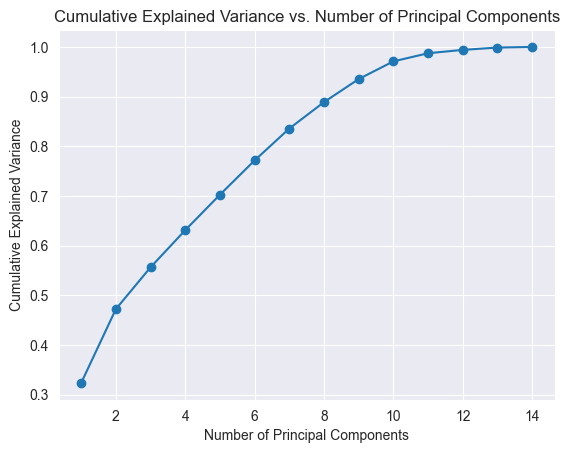

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

columns_to_standardized= ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'MaxTime', 'PrepTime', 'CookTime', 'Age', 'RecipeServings']
#minmax_scaler = MinMaxScaler()
#df[columns_to_standardized] = minmax_scaler.fit_transform(df[columns_to_standardized])

scaler = StandardScaler()


df[columns_to_standardized] = scaler.fit_transform(df[columns_to_standardized])


transform_pca = PCA()
principal_components = transform_pca.fit_transform(df[columns_to_standardized])


explained_variance_ratio = transform_pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

In [34]:
df[columns_to_standardized]

,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,MaxTime,PrepTime,CookTime,Age,RecipeServings
0,-0.256826,-0.544289,-0.473183,-0.542488,-0.230799,-0.505004,-0.575642,-0.324389,-0.677249,-0.064021,-0.062191,-0.048947,0.139266,-0.749502
1,-0.066011,-0.113590,-0.247583,-0.328143,-0.011513,-0.113206,-0.454205,-0.261234,-0.043768,-0.055557,-0.049943,-0.043700,1.680470,-0.037191
2,-0.266552,-0.241453,-0.377930,-0.542488,-0.230799,-0.485414,-0.514923,-0.318514,-0.669476,-0.062116,-0.057598,-0.048422,-1.236809,0.047112
3,0.820796,0.554891,-0.112222,-0.542488,-0.195398,1.987036,9.959047,-0.093799,2.000472,-0.055560,-0.034632,-0.048947,-1.236809,-0.749502
4,0.212564,-0.297534,-0.317770,0.153027,0.086452,1.083839,0.107443,0.719872,0.026187,-0.022647,-0.019322,-0.017464,-1.236809,0.047112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97376,-0.015078,0.160084,0.278819,0.088534,-0.110616,-0.060623,-0.363127,0.076572,-0.475157,-0.034404,-0.042287,-0.022711,-0.906551,0.776879
97377,0.262755,0.202705,-0.047049,-0.332569,-0.133202,0.605434,0.987864,-0.126111,0.566395,-0.046132,-0.034632,-0.038453,0.524567,-0.444226
97378,0.329206,-0.530829,-0.468170,-0.542488,-0.228893,1.973633,0.486935,3.050733,-0.634499,-0.017950,-0.034632,-0.006970,0.524567,0.047112
97379,0.134605,-0.100130,0.138445,-0.110637,-0.154958,0.397162,0.031545,0.524532,0.030074,-0.061191,-0.062191,-0.045799,0.524567,-0.749502


# Fit Model

In [35]:
X = df.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', 'RecipeCategory_Other', 'RecipeServings' ], axis=1)
y = df['Like']

In [36]:
# split data into learning and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=31, min_samples_leaf=5, random_state=2024)
model.fit(X_train, y_train)
min_samples_split_value = model.min_samples_split
print("min_samples_split:", min_samples_split_value)

from sklearn.metrics import balanced_accuracy_score, accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_accuracy)

from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(model, n_estimators=100, random_state=2024)
bagging_classifier.fit(X_train, y_train)

predictions_bagging = bagging_classifier.predict(X_test)
accuracy_bagging = accuracy_score(y_test, predictions_bagging)
balanced_accuracy_bagging = balanced_accuracy_score(y_test, predictions_bagging)
print("Accuracy with bagging:", accuracy_bagging)
print("Balanced Accuracy with bagging:", balanced_accuracy_bagging)

min_samples_split: 2
Accuracy: 0.8683552969365053
Balanced Accuracy: 0.6889227284236876
Accuracy with bagging: 0.897621085059045
Balanced Accuracy with bagging: 0.6926104680141547


In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.4, max_depth=5, random_state=seed)

train_model.fit(X_train,y_train)

predictions = train_model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.7131959482992307


716156123859597